In [6]:
import RAM_helpers
import numpy as np
import seaborn as sns
import numexpr
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import pdb
import os
import h5py

from tqdm import tqdm
from xarray import concat
from ptsa.data.filters.MorletWaveletFilterCpp import MorletWaveletFilterCpp
from ptsa.data.TimeSeriesX import TimeSeriesX
from SubjectLevel.Analyses import subject_SME
from SubjectLevel.Analyses.subject_classifier_by_region import SubjectClassifier as sc
from scipy.stats import ttest_rel, levene, fisher_exact, zscore, zmap, ttest_1samp
matplotlib.pyplot.ion()

In [4]:
def fr6_stim_info(events, elec_info):
    """
    Figure out a few things about the catFR6/FR6 events.
    
    - What electrode pairs were stimulated
    - What type of stim list is it? A, B, or A+B?    
    """
    
    # make sure alll elec_info strings are upper
    for e_ind in range(len(elec_info.tag_name)):
        elec_info[e_ind].tag_name = elec_info[e_ind].tag_name.upper() 
    
    stim_on = events[(events.type=='STIM_ON') & (events.stim_list==1)]
    non_stim = events[(events.type=='WORD') & (events.phase=='NON-STIM')]    
    sessions = np.unique(events.session)
    stim_info = {}
    for sess in sessions:
        sess_ev = events[(events.type=='WORD') & (events.session==sess)] 
        stim_on_sess = stim_on[stim_on.session==sess]
        
        # get unique stim params
        anode_label = stim_on_sess.stim_params['anode_label']
        cathode_label = stim_on_sess.stim_params['cathode_label']        
        stim_sites, indices = np.unique(np.concatenate([anode_label, cathode_label],1), axis=0, return_inverse=True)
        
        # if there aren't 3 unqiue stim params, then somthint is weird
        if stim_sites.shape[0] != 3:
            print('%s: something wrong?' % events[0].subject)
            continue
#             return
        
        # now we will label lists as being stim locaiton A, B, or both
        stim_info[sess] = {}
        ab = ['B', 'A']
        stim_site_trial_labels = np.empty(indices.shape, dtype='U2')
        stim_site_trial_nums = np.empty(indices.shape, dtype=int)        
        for i, this_stim_site in enumerate(stim_sites):
            if len(list(filter(None,this_stim_site))) == 2:
                this_label = ab.pop()
            elif len(list(filter(None,this_stim_site))) == 4:
                this_label = 'AB'        
            stim_site_trial_labels[indices==i] = this_label
            stim_site_trial_nums[indices==i] = stim_on_sess[indices==i].list
            
        # get electrode tag and region A
        A_tag = anode_label[stim_site_trial_labels=='A'][0,0]+'-'+cathode_label[stim_site_trial_labels=='A'][0,0]
        A_tag = A_tag.upper()
        A_elec_info = elec_info[elec_info.tag_name==A_tag]
        A_elec_str = A_elec_info.loc_tag[0] if A_elec_info.loc_tag else A_elec_info.anat_region[0]
        A_region = get_elec_region(A_elec_str, A_tag, events[0].subject)
        A_hemi = 'right' if A_elec_info.xyz_indiv[0][0] > 0 else 'left'
        
        # get electrode tag and region B       
        B_tag = anode_label[stim_site_trial_labels=='B'][0,0]+'-'+cathode_label[stim_site_trial_labels=='B'][0,0]
        B_tag = B_tag.upper()
        B_elec_info = elec_info[elec_info.tag_name==B_tag]
        B_elec_str = B_elec_info.loc_tag[0] if B_elec_info.loc_tag else B_elec_info.anat_region[0]
        B_region = get_elec_region(B_elec_str, B_tag, events[0].subject)        
        B_hemi = 'right' if B_elec_info.xyz_indiv[0][0] > 0 else 'left'        
        
        # store the info for this session
        stim_info[sess]['stim_site_trial_labels'] = stim_site_trial_labels     
        stim_info[sess]['stim_site_trial_nums'] = stim_site_trial_nums    
        stim_info[sess]['stim_events'] = stim_on_sess
        stim_info[sess]['A_tag'] = A_tag
        stim_info[sess]['A_region'] = A_region
        stim_info[sess]['A_hemi'] = A_hemi        
        stim_info[sess]['B_tag'] = B_tag
        stim_info[sess]['B_region'] = B_region        
        stim_info[sess]['B_hemi'] = B_hemi        
        
        # also store non-stim events
        stim_info[sess]['sham_events'] = non_stim[non_stim.session==sess]
        stim_info[sess]['session_events'] = sess_ev
        
        # finally add the recalled info to the stim events
        for stim_ev in range(stim_info[sess]['stim_events'].shape[0]):
            word = stim_info[sess]['stim_events'][stim_ev].item_name 
            recalled = sess_ev[sess_ev.item_name == word].recalled
            stim_info[sess]['stim_events'][stim_ev].recalled = recalled
        
    return stim_info

### loop to compute results

In [7]:
res_all = []
tasks = ['catFR6', 'FR6']
subjs = [['R1384J','0'], ['R1397D','0'], ['R1400N','0'], ['R1403N','0'], ['R1404E','0'], ['R1409D','0']]
for task in tasks:
    for subj in subjs:
        print(subj)
        fname = '/Users/jmiller/Desktop/FR6/%s_%s_with_elec_data.p' % (subj[0], task)
        if os.path.exists(fname):
            res = joblib.load(fname)
            res_all.append(res)

['R1384J', '0']
['R1397D', '0']
['R1400N', '0']
['R1403N', '0']
['R1404E', '0']
['R1409D', '0']
['R1384J', '0']
['R1397D', '0']
['R1400N', '0']
['R1403N', '0']
['R1404E', '0']
['R1409D', '0']


In [10]:
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18

### Single vs multi site stim change in classifier output

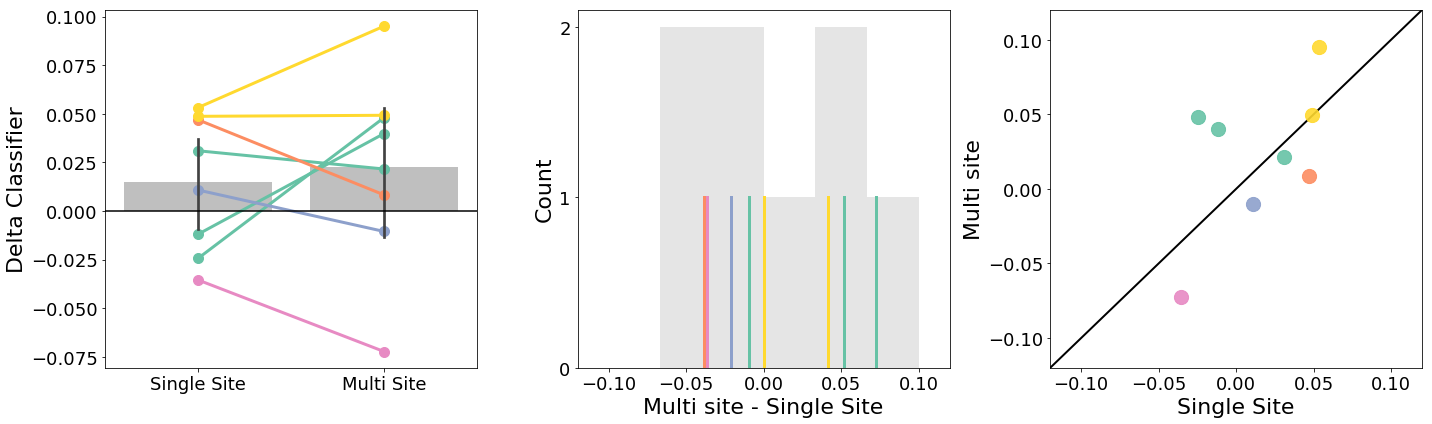

In [626]:
subjs = []
single_site_delta = []
multi_site_delta = []
aucs = []
for res in res_all:
    for res_sess in res:
        subjs.append(res[res_sess]['subj'])
        aucs.append(res[res_sess]['non_stim_auc'])
        
        # change single site
        a_or_b = (res[res_sess]['stim_site_trial_labels'] == 'A') | (res[res_sess]['stim_site_trial_labels'] == 'B')
        delta_class_a_or_b = res[res_sess]['post_probs_bad_chans'][a_or_b] - res[res_sess]['pre_probs_bad_chans'][a_or_b]
        single_site_delta.append(delta_class_a_or_b.mean())
        
        # change multi site
        a_and_b = res[res_sess]['stim_site_trial_labels'] == 'AB'
        delta_class_a_and_b = res[res_sess]['post_probs_bad_chans'][a_and_b] - res[res_sess]['pre_probs_bad_chans'][a_and_b]
        multi_site_delta.append(delta_class_a_and_b.mean())
        
subjs = np.array(subjs)
single_site_delta = np.array(single_site_delta)
multi_site_delta = np.array(multi_site_delta)
aucs = np.array(aucs)

auc_thresh = .55
colors = np.array(sns.color_palette('Set2'))
fig, (ax,ax2,ax3) = plt.subplots(1,3)
for data in zip(subjs, single_site_delta, multi_site_delta, aucs):
    if data[3] > auc_thresh:
        c = colors[np.where(np.unique(subjs)==data[0])[0][0]]
        ax.plot([0,1], [data[1], data[2]], '.-', c=c, lw=3, markersize=20)
        ax2.plot([data[2]-data[1]]*2, [0,1], c=c, lw=3)
        ax3.scatter(x=data[1], y=data[2], s=200, alpha=.9, c=c)
    
sns.barplot(data=[single_site_delta[aucs>auc_thresh], multi_site_delta[aucs>auc_thresh]], color=[.75,.75,.75],ax=ax)
ax.plot(ax.get_xlim(), [0,0], '-k')
ax.set_xticklabels(['Single Site', 'Multi Site'])
ax.set_ylabel('Delta Classifier')

sns.distplot(multi_site_delta[aucs>auc_thresh]-single_site_delta[aucs>auc_thresh],color=[.75,.75,.75],bins=np.linspace(-.1,.1,7),ax=ax2,hist_kws={'normed': False},kde=False)
ax2.set_xlim(-0.12, .12)
ax2.set_xlabel('Multi site - Single Site')
ax2.set_ylabel('Count')
ax2.set_yticks([0,1,2])

ax3.plot([-.12, .12], [-.12, .12], '-k', zorder=-1, lw=2)
ax3.set_ylim(-.12, .12)
ax3.set_xlim(-.12, .12)
ax3.set_xlabel('Single Site')
ax3.set_ylabel('Multi site')
fig.set_size_inches(20,6)
plt.tight_layout()

# plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/single_multi_delta_class_.55_aucs.pdf', bbox_inches='tight')

### single site lateral temporal lobe and single site frontal lobe stim change in classifier output

/Users/jmiller/anaconda2/envs/fresh3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jmiller/anaconda2/envs/fresh3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


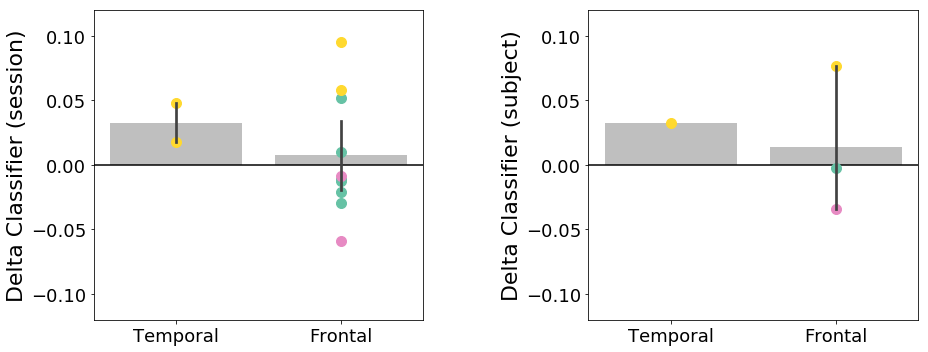

In [316]:
TC_subjs = []
TC_delta = []
FC_subjs = []
FC_delta = []
TC_aucs = []
FC_aucs = []

for res in res_all:
    for res_sess in res:
        for site in ['A', 'B']:
            stim_inds = res[res_sess]['stim_site_trial_labels'] == site
            delta = np.mean(res[res_sess]['post_probs_bad_chans'][stim_inds] - res[res_sess]['pre_probs_bad_chans'][stim_inds])
            if res[res_sess][site+'_region'] == 'TC':
                TC_delta.append(delta)
                TC_subjs.append(res[res_sess]['subj'])
                TC_aucs.append(res[res_sess]['non_stim_auc'])                
            elif res[res_sess][site+'_region'] == 'FC':
                FC_delta.append(delta)
                FC_subjs.append(res[res_sess]['subj'])                
                FC_aucs.append(res[res_sess]['non_stim_auc'])                     

TC_aucs = np.array(TC_aucs)            
FC_aucs = np.array(FC_aucs)            
TC_subjs = np.array(TC_subjs)
TC_delta = np.array(TC_delta)
FC_subjs = np.array(FC_subjs)
FC_delta = np.array(FC_delta)

fig, (ax,ax2) = plt.subplots(1,2)
colors = np.array(sns.color_palette('Set2'))
auc_thresh = .6

for tc_data in zip(TC_subjs, TC_delta, TC_aucs):
    if tc_data[2] > auc_thresh:
        c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==tc_data[0])[0][0]]
        ax.plot([0], [tc_data[1]], '.-', c=c, lw=3, markersize=20)
    
for fc_data in zip(FC_subjs, FC_delta, FC_aucs):
    if fc_data[2] > auc_thresh:
        c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==fc_data[0])[0][0]]
        ax.plot([1], [fc_data[1]], '.-', c=c, lw=3, markersize=20)    

sns.barplot(data=[TC_delta[TC_aucs>auc_thresh], FC_delta[FC_aucs>auc_thresh]], color=[.75,.75,.75],ax=ax)
ax.set_ylim(-.12,.12)
ax.set_xlim(-.5,1.5)
ax.plot(ax.get_xlim(), [0,0], '-k', zorder=1)
ax.set_xticklabels(['Temporal', 'Frontal'])
ax.set_ylabel('Delta Classifier (session)')

tc_means = []
for s in np.unique(TC_subjs):
    c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==s)[0][0]]
    m = np.mean(TC_delta[(TC_subjs==s) & (TC_aucs>auc_thresh)])
    tc_means.append(m)    
    ax2.plot([0], [m], '.-', c=c, lw=3, markersize=20)
    
fc_means = []
for s in np.unique(FC_subjs):
    c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==s)[0][0]]
    m = np.mean(FC_delta[(FC_subjs==s) & (FC_aucs>auc_thresh)])
    fc_means.append(m)
    ax2.plot([1], [m], '.-', c=c, lw=3, markersize=20)

sns.barplot(data=[tc_means, fc_means], color=[.75,.75,.75],ax=ax2)
ax2.set_ylim(-.12,.12)
ax2.set_xlim(-.5,1.5)
ax2.set_xticklabels(['Temporal', 'Frontal'])
ax2.set_ylabel('Delta Classifier (subject)')
ax2.plot(ax2.get_xlim(), [0,0], '-k', zorder=1)

fig.set_size_inches(13,5)
plt.tight_layout()
plt.subplots_adjust(wspace=.5)

plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/temporal_frontal_delta_class_.6_aucs.pdf', bbox_inches='tight')

### site a vs site b vs both delta classifier

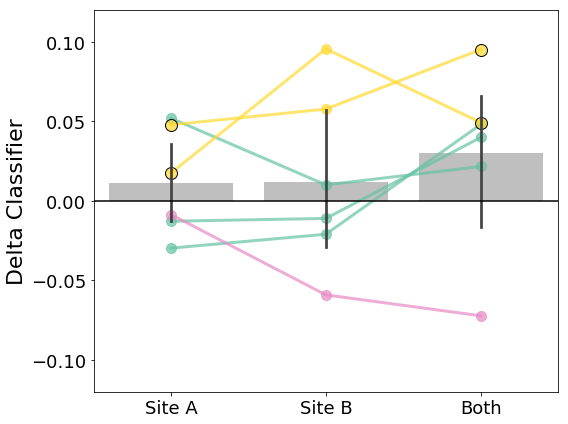

In [328]:
subjs = []
a_site_delta = []
a_region = []
b_site_delta = []
b_region = []
multi_site_delta = []
aucs = []

for res in res_all:
    for res_sess in res:
        subjs.append(res[res_sess]['subj'])
        aucs.append(res[res_sess]['non_stim_auc']) 
        
        # change single site a
        a = res[res_sess]['stim_site_trial_labels'] == 'A'
        delta_class_a = res[res_sess]['post_probs_bad_chans'][a] - res[res_sess]['pre_probs_bad_chans'][a]
        a_site_delta.append(delta_class_a.mean())
        a_region.append(res[res_sess]['A_region'])
        
        # change single site a
        b = res[res_sess]['stim_site_trial_labels'] == 'B'
        delta_class_b = res[res_sess]['post_probs_bad_chans'][b] - res[res_sess]['pre_probs_bad_chans'][b]
        b_site_delta.append(delta_class_b.mean())    
        b_region.append(res[res_sess]['B_region'])        
        
        # change multi site
        a_and_b = res[res_sess]['stim_site_trial_labels'] == 'AB'
        delta_class_a_and_b = res[res_sess]['post_probs_bad_chans'][a_and_b] - res[res_sess]['pre_probs_bad_chans'][a_and_b]
        multi_site_delta.append(delta_class_a_and_b.mean())
        
subjs = np.array(subjs)
aucs = np.array(aucs)
a_site_delta = np.array(a_site_delta)
b_site_delta = np.array(b_site_delta)
multi_site_delta = np.array(multi_site_delta)
a_region = np.array(a_region)
b_region = np.array(b_region)

auc_thresh = .6
colors = np.array(sns.color_palette('Set2'))
fig, ax = plt.subplots(1,1)
for data in zip(subjs, a_site_delta, b_site_delta, multi_site_delta, a_region, b_region, aucs):
    if data[6] > auc_thresh:
        c = colors[np.where(np.unique(subjs)==data[0])[0][0]]    
        ax.plot([0,1,2], [data[1], data[2], data[3]], '.-', c=c, lw=3, markersize=20, alpha=.7)
        if data[4]=='TC':
            ax.plot([0], [data[1]], 'o', markersize=12, markeredgecolor='k', color='None', lw=2)
        if data[5]=='TC':
            ax.plot([1], [data[2]], 'o', markersize=12, markeredgecolor='k', color='None', lw=2)
        if (data[4]=='TC') | (data[5]=='TC'):
            ax.plot([2], [data[3]], 'o', markersize=12, markeredgecolor='k', color='None', lw=2)        
    
sns.barplot(data=[a_site_delta[aucs>auc_thresh], b_site_delta[aucs>auc_thresh], multi_site_delta[aucs>auc_thresh]], color=[.75,.75,.75],ax=ax)
ax.plot(ax.get_xlim(), [0,0], '-k')
ax.set_xticklabels(['Site A', 'Site B', 'Both'])
ax.set_ylabel('Delta Classifier')
ax.set_ylim(-.12, .12)

# sns.distplot(multi_site_delta-single_site_delta,color=[.75,.75,.75],ax=ax2,hist_kws={'normed': False},kde=False)
# ax2.set_xlim(-0.1, .1)
fig.set_size_inches(8,6)
plt.tight_layout()
plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/delta_class_a_b_both_.6_aucs.pdf', bbox_inches='tight')

In [359]:
np.mean(b_site_delta - a_site_delta)

0.0080448191736679341

In [358]:
ttest_1samp(b_site_delta - a_site_delta, 0)

Ttest_1sampResult(statistic=0.97426595582058917, pvalue=0.34770551593930599)

### Memory?

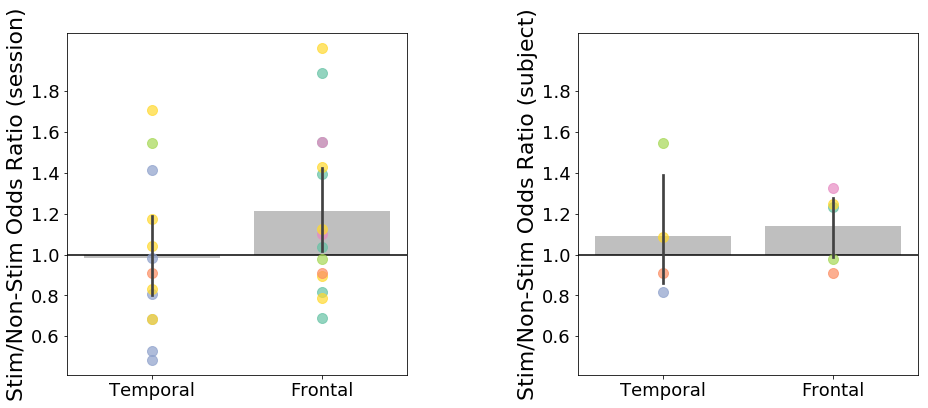

In [804]:
TC_subjs = []
TC_mem = []
TC_odds = []
TC_auc = []
TC_delta = []
FC_subjs = []
FC_mem = []
FC_auc = []
FC_odds = []
FC_delta = []

for res in res_all:
    for res_sess in res:
        
        
        non_stim_lists = np.setdiff1d(res[res_sess]['lists_all_items'], np.unique(res[res_sess]['stim_site_trial_nums']))
        non_stim_lists = non_stim_lists[non_stim_lists!=-1]
        non_stim_lists = np.in1d(res[res_sess]['lists_all_items'], non_stim_lists)
        baseline_mem = np.mean(res[res_sess]['recalled_all_items'][non_stim_lists])        
        baseline_odds = baseline_mem / (1. - baseline_mem)

        
        for site in ['A', 'B']:
            stim_inds = res[res_sess]['stim_site_trial_labels'] == site
            delta_class = np.mean(res[res_sess]['post_probs_bad_chans'][stim_inds] - res[res_sess]['pre_probs_bad_chans'][stim_inds])                        
            stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][stim_inds])
            stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
            mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
            mean_rec_stim_site_list_items_odds = mean_rec_stim_site_list_items / (1. - mean_rec_stim_site_list_items)
            delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
            odds_mem = mean_rec_stim_site_list_items_odds / baseline_odds
            
            if res[res_sess][site+'_region'] == 'TC':
                TC_mem.append(delta_mem)
                TC_odds.append(odds_mem)                
                TC_subjs.append(res[res_sess]['subj'])
                TC_auc.append(res[res_sess]['non_stim_auc'])
                TC_delta.append(delta_class)
            elif res[res_sess][site+'_region'] == 'FC':
                FC_mem.append(delta_mem)
                FC_odds.append(odds_mem)                          
                FC_subjs.append(res[res_sess]['subj'])      
                FC_auc.append(res[res_sess]['non_stim_auc'])                
                FC_delta.append(delta_class)
                
TC_subjs = np.array(TC_subjs)
TC_mem = np.array(TC_mem)
TC_auc = np.array(TC_auc)
TC_odds = np.array(TC_odds)
TC_delta = np.array(TC_delta)
FC_subjs = np.array(FC_subjs)
FC_mem = np.array(FC_mem)
FC_auc = np.array(FC_auc)
FC_odds = np.array(FC_odds)
FC_delta.append(FC_delta)

FC_mem = FC_odds-1
TC_mem = TC_odds-1

fig, (ax,ax2) = plt.subplots(1,2)
colors = np.array(sns.color_palette('Set2'))

auc_thresh = .4
for tc_data in zip(TC_subjs, TC_mem, TC_auc):
    if tc_data[2] > auc_thresh:
        c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==tc_data[0])[0][0]]
        ax.plot([0], [tc_data[1]], '.-', c=c, lw=3, markersize=20, alpha=.7)
    
for fc_data in zip(FC_subjs, FC_mem, FC_auc):
    if fc_data[2] > auc_thresh:
        c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==fc_data[0])[0][0]]
        ax.plot([1], [fc_data[1]], '.-', c=c, lw=3, markersize=20, alpha=.7)    

sns.barplot(data=[TC_mem[TC_auc>auc_thresh], FC_mem[FC_auc>auc_thresh]], color=[.75,.75,.75],ax=ax)
# ax.set_ylim(-.1,.1)
ax.set_xlim(-.5,1.5)
ax.plot(ax.get_xlim(), [0,0], '-k', zorder=1)
ax.set_yticks(np.arange(-.4, .81, .2))
ax.set_yticklabels(np.arange(-.4, .81, .2)+1)

ax.set_xticklabels(['Temporal', 'Frontal'])
ax.set_ylabel('Stim/Non-Stim Odds Ratio (session)')
# ax.set_ylim(-30, 70)

tc_means = []
for s in np.unique(TC_subjs):
    c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==s)[0][0]]
    m = np.mean(TC_mem[(TC_subjs==s) & (TC_auc>auc_thresh)])
    tc_means.append(m)    
    ax2.plot([0], [m], '.-', c=c, lw=3, markersize=20, alpha=.7)
    
fc_means = []
for s in np.unique(FC_subjs):
    c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==s)[0][0]]
    m = np.mean(FC_mem[(FC_subjs==s) & (FC_auc>auc_thresh)])
    fc_means.append(m)
    ax2.plot([1], [m], '.-', c=c, lw=3, markersize=20, alpha=.7)

sns.barplot(data=[tc_means, fc_means], color=[.75,.75,.75],ax=ax2)
# ax2.set_ylim(-.1,.1)
ax2.set_xlim(-.5,1.5)
ax2.plot(ax2.get_xlim(), [0,0], '-k', zorder=1)
ax2.set_xticklabels(['Temporal', 'Frontal'])
ax2.set_ylabel('Stim/Non-Stim Odds Ratio (subject)')
# ax2.set_ylim(-30, 70)

ax2.set_yticks(np.arange(-.4, .81, .2))
ax2.set_yticklabels(np.arange(-.4, .81, .2)+1)
ax2.set_ylim(ax.get_ylim())

fig.set_size_inches(13,6)
plt.tight_layout()
plt.subplots_adjust(wspace=.5)

plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/delta_memory_all_aucs.pdf', bbox_inches='tight')

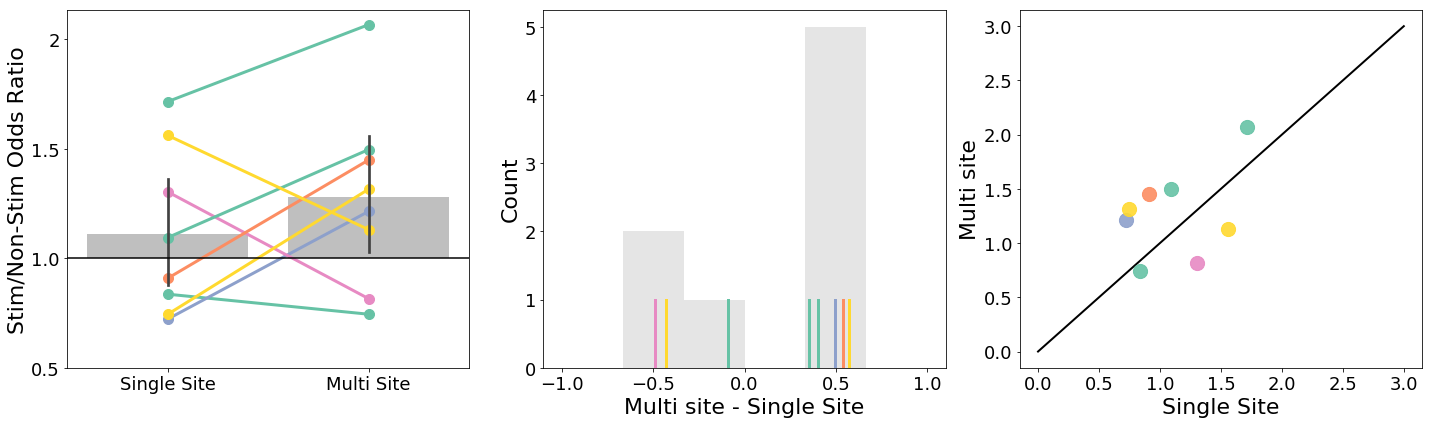

In [755]:
subjs = []
single_site_delta_class = []
multi_site_delta_class = []
single_site_delta = []
multi_site_delta = []
aucs = []

for res in res_all:
    for res_sess in res:
        subjs.append(res[res_sess]['subj'])
        aucs.append(res[res_sess]['non_stim_auc'])
        non_stim_lists = np.setdiff1d(res[res_sess]['lists_all_items'], np.unique(res[res_sess]['stim_site_trial_nums']))
        non_stim_lists = non_stim_lists[non_stim_lists!=-1]
        non_stim_lists = np.in1d(res[res_sess]['lists_all_items'], non_stim_lists)
        baseline_mem = np.mean(res[res_sess]['recalled_all_items'][non_stim_lists])        
        baseline_odds = baseline_mem / (1. - baseline_mem)
                
        # change single site
        a_or_b = (res[res_sess]['stim_site_trial_labels'] == 'A') | (res[res_sess]['stim_site_trial_labels'] == 'B')
        stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][a_or_b])
        stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
        mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
        mean_rec_stim_site_list_items_odds = mean_rec_stim_site_list_items / (1. - mean_rec_stim_site_list_items)
        delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
        odds_mem = mean_rec_stim_site_list_items_odds / baseline_odds        
        delta_class_a_or_b = res[res_sess]['post_probs_bad_chans'][a_or_b] - res[res_sess]['pre_probs_bad_chans'][a_or_b]
        single_site_delta_class.append(delta_class_a_or_b.mean())        
        single_site_delta.append(odds_mem)
        
        # change multi site
        a_and_b = res[res_sess]['stim_site_trial_labels'] == 'AB'
        stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][a_and_b])
        stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
        mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
        mean_rec_stim_site_list_items_odds = mean_rec_stim_site_list_items / (1. - mean_rec_stim_site_list_items)
        delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
        odds_mem = mean_rec_stim_site_list_items_odds / baseline_odds  
        multi_site_delta.append(odds_mem)
        delta_class_a_and_b = res[res_sess]['post_probs_bad_chans'][a_and_b] - res[res_sess]['pre_probs_bad_chans'][a_and_b]
        multi_site_delta_class.append(delta_class_a_and_b.mean())
        
subjs = np.array(subjs)
single_site_delta = np.array(single_site_delta)
multi_site_delta = np.array(multi_site_delta)
single_site_delta_class = np.array(single_site_delta_class)
multi_site_delta_class = np.array(multi_site_delta_class)
aucs = np.array(aucs)

auc_thresh = .55
colors = np.array(sns.color_palette('Set2'))
fig, (ax,ax2,ax3) = plt.subplots(1,3)
for data in zip(subjs, single_site_delta-1, multi_site_delta-1, aucs):
    if data[3] > auc_thresh:
        c = colors[np.where(np.unique(subjs)==data[0])[0][0]]
        ax.plot([0,1], [data[1], data[2]], '.-', c=c, lw=3, markersize=20)
        ax2.plot([data[2]-data[1]]*2, [0,1], c=c, lw=3)
        ax3.scatter(x=data[1]+1, y=data[2]+1, s=200, alpha=.9, c=c)
    
sns.barplot(data=[single_site_delta[aucs>auc_thresh]-1, multi_site_delta[aucs>auc_thresh]-1], color=[.75,.75,.75],ax=ax)
ax.plot(ax.get_xlim(), [0,0], '-k')
ax.set_xticklabels(['Single Site', 'Multi Site'])
ax.set_ylabel('Stim/Non-Stim Odds Ratio')
ax.set_yticks([-.5,0,.5,1])
ax.set_yticklabels([0.5, 1., 1.5, 2])

sns.distplot(multi_site_delta[aucs>auc_thresh]-single_site_delta[aucs>auc_thresh],color=[.75,.75,.75],bins=np.linspace(-1,1,7),ax=ax2,hist_kws={'normed': False},kde=False)
# ax2.set_xlim(-0.12, .12)
ax2.set_xlabel('Multi site - Single Site')
ax2.set_ylabel('Count')
# ax2.set_yticks([0,1,2])

ax3.plot([0, 3], [0, 3], '-k', zorder=-1, lw=2)
# ax3.set_ylim(-.12, .12)
# ax3.set_xlim(-.12, .12)
ax3.set_xlabel('Single Site')
ax3.set_ylabel('Multi site')
fig.set_size_inches(20,6)
plt.tight_layout()

# plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/single_multi_delta_mem_.6_aucs.pdf', bbox_inches='tight')

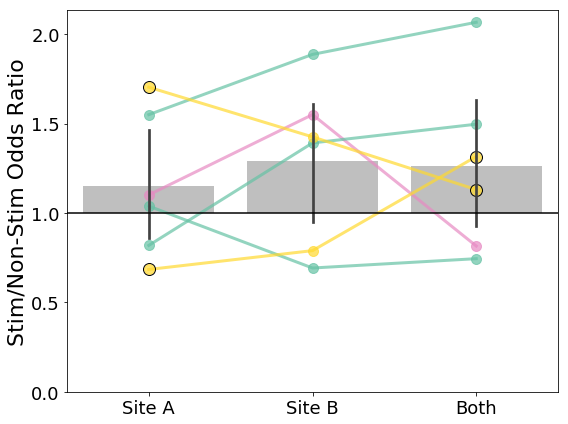

In [833]:
subjs = []
a_site_delta = []
a_region = []
b_site_delta = []
b_region = []
multi_site_delta = []
aucs = []

for res in res_all:
    for res_sess in res:
        subjs.append(res[res_sess]['subj'])
        aucs.append(res[res_sess]['non_stim_auc']) 
        
        non_stim_lists = np.setdiff1d(res[res_sess]['lists_all_items'], np.unique(res[res_sess]['stim_site_trial_nums']))
        non_stim_lists = non_stim_lists[non_stim_lists!=-1]
        non_stim_lists = np.in1d(res[res_sess]['lists_all_items'], non_stim_lists)
        baseline_mem = np.mean(res[res_sess]['recalled_all_items'][non_stim_lists])        
        baseline_odds = baseline_mem / (1. - baseline_mem)        
        
        # change single site a
        a = res[res_sess]['stim_site_trial_labels'] == 'A'
        delta_class_a = res[res_sess]['post_probs_bad_chans'][a] - res[res_sess]['pre_probs_bad_chans'][a]                
        stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][a])
        stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
        mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
        mean_rec_stim_site_list_items_odds = mean_rec_stim_site_list_items / (1. - mean_rec_stim_site_list_items)
        delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
        odds_mem = mean_rec_stim_site_list_items_odds / baseline_odds        
        a_site_delta.append(odds_mem)
        a_region.append(res[res_sess]['A_region'])
        
        # change single site b
        b = res[res_sess]['stim_site_trial_labels'] == 'B'
        delta_class_b = res[res_sess]['post_probs_bad_chans'][b] - res[res_sess]['pre_probs_bad_chans'][b]                
        stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][b])
        stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
        mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
        mean_rec_stim_site_list_items_odds = mean_rec_stim_site_list_items / (1. - mean_rec_stim_site_list_items)
        delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
        odds_mem = mean_rec_stim_site_list_items_odds / baseline_odds        
        b_site_delta.append(odds_mem)  
        b_region.append(res[res_sess]['B_region'])        
        
        # change multi site
        a_and_b = res[res_sess]['stim_site_trial_labels'] == 'AB'        
        stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][a_and_b])
        stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
        mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
        mean_rec_stim_site_list_items_odds = mean_rec_stim_site_list_items / (1. - mean_rec_stim_site_list_items)
        delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
        odds_mem = mean_rec_stim_site_list_items_odds / baseline_odds        
        multi_site_delta.append(odds_mem)  

        
subjs = np.array(subjs)
aucs = np.array(aucs)
a_site_delta = np.array(a_site_delta)
b_site_delta = np.array(b_site_delta)
multi_site_delta = np.array(multi_site_delta)
a_region = np.array(a_region)
b_region = np.array(b_region)

auc_thresh = .6
colors = np.array(sns.color_palette('Set2'))
fig, ax = plt.subplots(1,1)
for data in zip(subjs, a_site_delta-1, b_site_delta-1, multi_site_delta-1, a_region, b_region, aucs):
    if data[6] > auc_thresh:
        c = colors[np.where(np.unique(subjs)==data[0])[0][0]]    
        ax.plot([0,1,2], [data[1], data[2], data[3]], '.-', c=c, lw=3, markersize=20, alpha=.7)
        if data[4]=='TC':
            ax.plot([0], [data[1]], 'o', markersize=12, markeredgecolor='k', color='None', lw=2)
        if data[5]=='TC':
            ax.plot([1], [data[2]], 'o', markersize=12, markeredgecolor='k', color='None', lw=2)
        if (data[4]=='TC') | (data[5]=='TC'):
            ax.plot([2], [data[3]], 'o', markersize=12, markeredgecolor='k', color='None', lw=2)        
    
sns.barplot(data=[a_site_delta[aucs>auc_thresh]-1, b_site_delta[aucs>auc_thresh]-1, multi_site_delta[aucs>auc_thresh]-1], color=[.75,.75,.75],ax=ax)
ax.plot(ax.get_xlim(), [0,0], '-k')
ax.set_xticklabels(['Site A', 'Site B', 'Both'])
ax.set_ylabel('Stim/Non-Stim Odds Ratio')
# ax.set_ylim(-.12, .12)
ax.set_yticks(np.arange(-1,1.2,.5))
ax.set_yticklabels(np.arange(-1,1.2,.5)+1)

# sns.distplot(multi_site_delta-single_site_delta,color=[.75,.75,.75],ax=ax2,hist_kws={'normed': False},kde=False)
# ax2.set_xlim(-0.1, .1)
fig.set_size_inches(8,6)
plt.tight_layout()
plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/delta_mem_a_b_both_.6_aucs.pdf', bbox_inches='tight')

### memory low biomarker

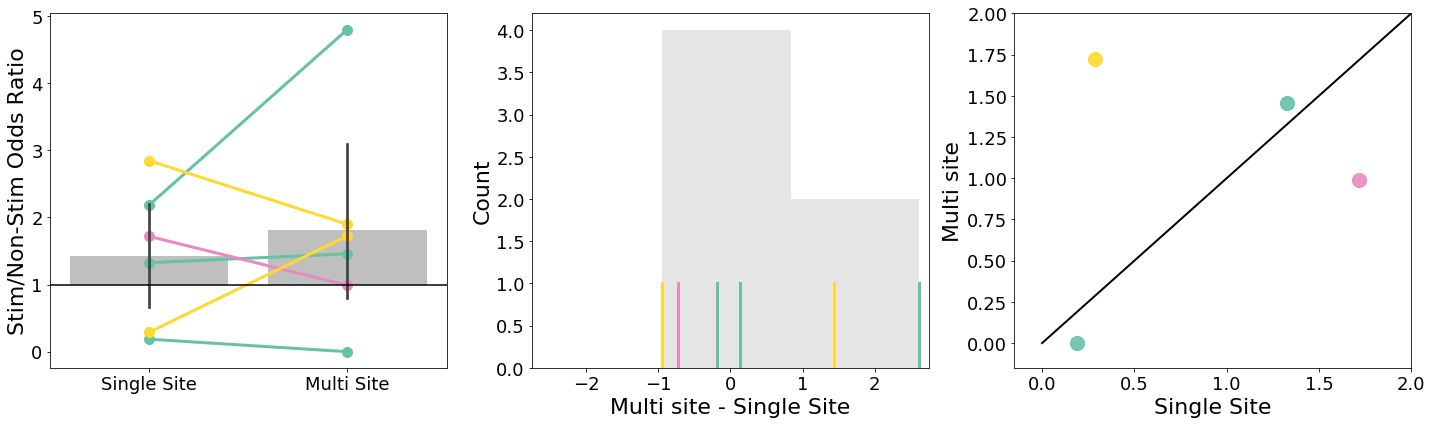

In [810]:
subjs = []
single_site_delta_class = []
multi_site_delta_class = []
single_site_delta = []
multi_site_delta = []
aucs = []

for res in res_all:
    for res_sess in res:
        subjs.append(res[res_sess]['subj'])
        aucs.append(res[res_sess]['non_stim_auc'])
        probs = res[res_sess]['enc_probs_bad_chans'][res[res_sess]['stim_list_field']==0]
        good_lists = res[res_sess]['lists_all_items'] > -1
        recalled = res[res_sess]['recalled_all_items'][good_lists]
        recalled = recalled[res[res_sess]['stim_list_field']==0]
        thresh = np.percentile(res[res_sess]['enc_probs_bad_chans'], 40)
        thresh=np.percentile(res[res_sess]['enc_probs_bad_chans'], 33)
        thresh=np.percentile(res[res_sess]['enc_probs_bad_chans'][res[res_sess]['is_stim']==1],67)
#         thresh = np.percentile(res[res_sess]['enc_probs_bad_chans'], 33)
#         thresh = np.median(res[res_sess]['enc_probs_bad_chans'][res[res_sess]['is_stim']==1])
#         np.percentile(probs_stim, 67)
        
        baseline_mem = recalled[probs<thresh].mean()               
        baseline_odds = baseline_mem / (1. - baseline_mem)
                
        # change single site
        a_or_b = (res[res_sess]['stim_site_trial_labels'] == 'A') | (res[res_sess]['stim_site_trial_labels'] == 'B')
        stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][a_or_b])
        stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'][good_lists],stim_site_lists)
        probs_stim = res[res_sess]['enc_probs_bad_chans'][(stim_site_list_items) & (res[res_sess]['is_stim']==1)]                
        stim_mem = np.mean(res[res_sess]['recalled'][a_or_b][probs_stim<thresh])      
        
        stim_odds =  stim_mem / (1. - stim_mem)
        delta_mem = (stim_mem - baseline_mem) / baseline_mem * 100.
        odds_mem = stim_odds / baseline_odds        
        delta_class_a_or_b = res[res_sess]['post_probs_bad_chans'][a_or_b] - res[res_sess]['pre_probs_bad_chans'][a_or_b]
        single_site_delta_class.append(delta_class_a_or_b.mean())        
        single_site_delta.append(odds_mem)
        
        # change multi site
        a_and_b = res[res_sess]['stim_site_trial_labels'] == 'AB'
        stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][a_and_b])
        stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'][good_lists],stim_site_lists)
        probs_stim = res[res_sess]['enc_probs_bad_chans'][(stim_site_list_items) & (res[res_sess]['is_stim']==1)]                       
        stim_mem = np.mean(res[res_sess]['recalled'][a_and_b][probs_stim<thresh])      
        stim_odds =  stim_mem / (1. - stim_mem)
        delta_mem = (stim_mem - baseline_mem) / baseline_mem * 100.
        odds_mem = stim_odds / baseline_odds        
        multi_site_delta.append(odds_mem)
        delta_class_a_and_b = res[res_sess]['post_probs_bad_chans'][a_and_b] - res[res_sess]['pre_probs_bad_chans'][a_and_b]
        multi_site_delta_class.append(delta_class_a_and_b.mean())
        
subjs = np.array(subjs)
single_site_delta = np.array(single_site_delta)
multi_site_delta = np.array(multi_site_delta)
single_site_delta_class = np.array(single_site_delta_class)
multi_site_delta_class = np.array(multi_site_delta_class)
aucs = np.array(aucs)

auc_thresh = .6
colors = np.array(sns.color_palette('Set2'))
fig, (ax,ax2,ax3) = plt.subplots(1,3)
for data in zip(subjs, single_site_delta-1, multi_site_delta-1, aucs):
    if data[3] > auc_thresh:
        c = colors[np.where(np.unique(subjs)==data[0])[0][0]]
        ax.plot([0,1], [data[1], data[2]], '.-', c=c, lw=3, markersize=20)
        ax2.plot([data[2]-data[1]]*2, [0,1], c=c, lw=3)
        ax3.scatter(x=data[1]+1, y=data[2]+1, s=200, alpha=.9, c=c)
    
sns.barplot(data=[single_site_delta[aucs>auc_thresh]-1, multi_site_delta[aucs>auc_thresh]-1], color=[.75,.75,.75],ax=ax)
ax.plot(ax.get_xlim(), [0,0], '-k')
ax.set_xticklabels(['Single Site', 'Multi Site'])
ax.set_ylabel('Stim/Non-Stim Odds Ratio')
ax.set_yticks([-1,0,1,2,3,4])
ax.set_yticklabels([0,1,2,3,4,5])

sns.distplot(multi_site_delta[aucs>auc_thresh]-single_site_delta[aucs>auc_thresh],color=[.75,.75,.75],ax=ax2,hist_kws={'normed': False},kde=False)
ax2.set_xlim(-2.75, 2.75)
ax2.set_xlabel('Multi site - Single Site')
ax2.set_ylabel('Count')
# ax2.set_yticks([0,1,2])

ax3.plot([0, 5], [0, 5], '-k', zorder=-1, lw=2)
ax3.set_ylim(-.15,2)
ax3.set_xlim(-.15,2)
ax3.set_xlabel('Single Site')
ax3.set_ylabel('Multi site')
fig.set_size_inches(20,6)
plt.tight_layout()

plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/single_multi_delta_mem_.6_aucs_item.pdf', bbox_inches='tight')

0.406575193025
0.409438738889
0.395969860927
0.383938455663
0.449370913664
0.447668340451
0.444707334167
0.456267049708
0.446926792385
0.446977699514
0.458816955163
0.504302065029
0.45168745526
0.490668569243
0.431502194437
0.45098795499
0.411059919896
0.418430819506
0.43074392499
0.426577446815
0.435191620568
0.460509449834
0.440425138818
0.45545544476
0.438395512762
0.445793353055
0.439817196418
0.443532974183


/Users/jmiller/anaconda2/envs/fresh3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jmiller/anaconda2/envs/fresh3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


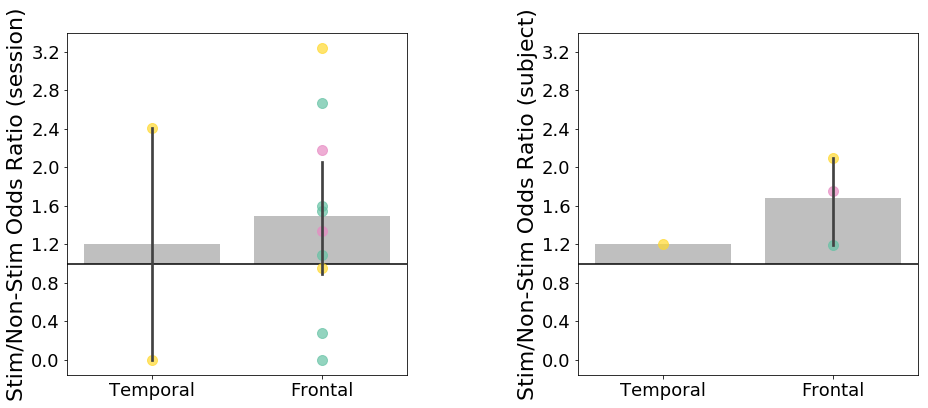

In [820]:
TC_subjs = []
TC_mem = []
TC_odds = []
TC_auc = []
TC_delta = []
FC_subjs = []
FC_mem = []
FC_auc = []
FC_odds = []
FC_delta = []

for res in res_all:
    for res_sess in res:
        
        
#         non_stim_lists = np.setdiff1d(res[res_sess]['lists_all_items'], np.unique(res[res_sess]['stim_site_trial_nums']))
#         non_stim_lists = non_stim_lists[non_stim_lists!=-1]
#         non_stim_lists = np.in1d(res[res_sess]['lists_all_items'], non_stim_lists)
#         baseline_mem = np.mean(res[res_sess]['recalled_all_items'][non_stim_lists])        
#         baseline_odds = baseline_mem / (1. - baseline_mem)
        
        probs = res[res_sess]['enc_probs_bad_chans'][res[res_sess]['stim_list_field']==0]
        good_lists = res[res_sess]['lists_all_items'] > -1
        recalled = res[res_sess]['recalled_all_items'][good_lists]
        recalled = recalled[res[res_sess]['stim_list_field']==0]
        thresh = np.percentile(res[res_sess]['enc_probs_bad_chans'], 40)
        thresh=np.percentile(res[res_sess]['enc_probs_bad_chans'], 33)
        print(thresh)
        thresh=np.percentile(res[res_sess]['enc_probs_bad_chans'][res[res_sess]['is_stim']==1],67)  
        print(thresh)
        baseline_mem = recalled[probs<thresh].mean()               
        baseline_odds = baseline_mem / (1. - baseline_mem)        

        
        for site in ['A', 'B']:
            stim_inds = res[res_sess]['stim_site_trial_labels'] == site
            delta_class = np.mean(res[res_sess]['post_probs_bad_chans'][stim_inds] - res[res_sess]['pre_probs_bad_chans'][stim_inds])                        
            stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][stim_inds])
            stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
            mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
            mean_rec_stim_site_list_items_odds = mean_rec_stim_site_list_items / (1. - mean_rec_stim_site_list_items)
            delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
            odds_mem = mean_rec_stim_site_list_items_odds / baseline_odds

            stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][stim_inds])
            stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'][good_lists],stim_site_lists)
            probs_stim = res[res_sess]['enc_probs_bad_chans'][(stim_site_list_items) & (res[res_sess]['is_stim']==1)]                
            stim_mem = np.mean(res[res_sess]['recalled'][stim_inds][probs_stim<thresh])      

            stim_odds =  stim_mem / (1. - stim_mem)
            delta_mem = (stim_mem - baseline_mem) / baseline_mem * 100.
            odds_mem = stim_odds / baseline_odds              
            
            
            if res[res_sess][site+'_region'] == 'TC':
                TC_mem.append(delta_mem)
                TC_odds.append(odds_mem)                
                TC_subjs.append(res[res_sess]['subj'])
                TC_auc.append(res[res_sess]['non_stim_auc'])
                TC_delta.append(delta_class)
            elif res[res_sess][site+'_region'] == 'FC':
                FC_mem.append(delta_mem)
                FC_odds.append(odds_mem)                          
                FC_subjs.append(res[res_sess]['subj'])      
                FC_auc.append(res[res_sess]['non_stim_auc'])                
                FC_delta.append(delta_class)
                
TC_subjs = np.array(TC_subjs)
TC_mem = np.array(TC_mem)
TC_auc = np.array(TC_auc)
TC_odds = np.array(TC_odds)
TC_delta = np.array(TC_delta)
FC_subjs = np.array(FC_subjs)
FC_mem = np.array(FC_mem)
FC_auc = np.array(FC_auc)
FC_odds = np.array(FC_odds)
FC_delta.append(FC_delta)

FC_mem = FC_odds-1
TC_mem = TC_odds-1

fig, (ax,ax2) = plt.subplots(1,2)
colors = np.array(sns.color_palette('Set2'))

auc_thresh = .6
for tc_data in zip(TC_subjs, TC_mem, TC_auc):
    if tc_data[2] > auc_thresh:
        c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==tc_data[0])[0][0]]
        ax.plot([0], [tc_data[1]], '.-', c=c, lw=3, markersize=20, alpha=.7)
    
for fc_data in zip(FC_subjs, FC_mem, FC_auc):
    if fc_data[2] > auc_thresh:
        c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==fc_data[0])[0][0]]
        ax.plot([1], [fc_data[1]], '.-', c=c, lw=3, markersize=20, alpha=.7)    

sns.barplot(data=[TC_mem[TC_auc>auc_thresh], FC_mem[FC_auc>auc_thresh]], color=[.75,.75,.75],ax=ax)
# ax.set_ylim(-.1,.1)
ax.set_xlim(-.5,1.5)
ax.plot(ax.get_xlim(), [0,0], '-k', zorder=1)
ax.set_yticks(np.arange(-1, 2.4, .4))
ax.set_yticklabels(np.arange(-1, 2.4, .4)+1)

ax.set_xticklabels(['Temporal', 'Frontal'])
ax.set_ylabel('Stim/Non-Stim Odds Ratio (session)')
# ax.set_ylim(-30, 70)

tc_means = []
for s in np.unique(TC_subjs):
    c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==s)[0][0]]
    m = np.mean(TC_mem[(TC_subjs==s) & (TC_auc>auc_thresh)])
    tc_means.append(m)    
    ax2.plot([0], [m], '.-', c=c, lw=3, markersize=20, alpha=.7)
    
fc_means = []
for s in np.unique(FC_subjs):
    c = colors[np.where(np.unique(np.concatenate([TC_subjs,FC_subjs]))==s)[0][0]]
    m = np.mean(FC_mem[(FC_subjs==s) & (FC_auc>auc_thresh)])
    fc_means.append(m)
    ax2.plot([1], [m], '.-', c=c, lw=3, markersize=20, alpha=.7)

sns.barplot(data=[tc_means, fc_means], color=[.75,.75,.75],ax=ax2)
# ax2.set_ylim(-.1,.1)
ax2.set_xlim(-.5,1.5)
ax2.plot(ax2.get_xlim(), [0,0], '-k', zorder=1)
ax2.set_xticklabels(['Temporal', 'Frontal'])
ax2.set_ylabel('Stim/Non-Stim Odds Ratio (subject)')
# ax2.set_ylim(-30, 70)

ax2.set_yticks(np.arange(-1, 2.4, .4))
ax2.set_yticklabels(np.arange(-1, 2.4, .4)+1)
ax2.set_ylim(ax.get_ylim())

fig.set_size_inches(13,6)
plt.tight_layout()
plt.subplots_adjust(wspace=.5)

plt.savefig('/Users/jmiller/Library/Mobile Documents/com~apple~CloudDocs/RAM_FR6/delta_memory_.6_aucs_item.pdf', bbox_inches='tight')

In [553]:
res[res_sess]['non_stim_auc']

0.61619433198380558

In [579]:
a_or_b = (res[res_sess]['stim_site_trial_labels'] == 'A') | (res[res_sess]['stim_site_trial_labels'] == 'B')
stim_mem = np.mean(res[res_sess]['recalled'][a_or_b])


stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][a_or_b])
stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])

(30,)

### power changes: single site, same region and hipp

In [15]:
res[res_sess].keys()

dict_keys(['A_tag', 'A_region', 'A_hemi', 'B_tag', 'B_region', 'B_hemi', 'pre_probs_all_chans', 'post_probs_all_chans', 'pre_probs_bad_chans', 'post_probs_bad_chans', 'power_change_all_chans', 'power_change_bad_chans', 'power_change_bad_volt_chans', 'all_chan_regions', 'bad_chan_regions', 'bad_volt_chan_regions', 'recalled', 'recalled_all_items', 'is_stim', 'lists_all_items', 'stim_site_trial_labels', 'stim_site_trial_nums', 'enc_probs_all_chans', 'enc_probs_bad_chans', 'stim_list_field', 'subj', 'non_stim_auc', 'non_stim_auc_bad_chans', 'elec_xyz', 'stim_elecs', 'bad_chans', 'bad_chans_with_voltage_test'])

In [17]:
res[res_sess]['power_change_bad_chans'].shape

(70, 8, 154)

In [21]:
res[res_sess]['elec_xyz'][~(res[res_sess]['bad_chans'] | res[res_sess]['stim_elecs'])].shape

(154,)

In [26]:
res[res_sess]['elec_xyz'][res[res_sess]['stim_elecs']]

array([array([ 31.32794   ,  30.43978   ,  -0.51199995]),
       array([-49.70696   ,  15.03433   , -46.96886758])], dtype=object)

In [11]:
power_change_local = []
power_change_volt_local = []
power_change_hipp = []

for res in res_all:
    for res_sess in res:
        
        
#         non_stim_lists = np.setdiff1d(res[res_sess]['lists_all_items'], np.unique(res[res_sess]['stim_site_trial_nums']))
#         non_stim_lists = non_stim_lists[non_stim_lists!=-1]
#         non_stim_lists = np.in1d(res[res_sess]['lists_all_items'], non_stim_lists)
#         baseline_mem = np.mean(res[res_sess]['recalled_all_items'][non_stim_lists])        

        
        for site in ['A', 'B']:
            stim_region = res[res_sess][site+'_region']
            stim_inds = res[res_sess]['stim_site_trial_labels'] == site            

            other_regions = np.array([x.split('-')[-1] for x in res[res_sess]['bad_chan_regions']])        
            print(np.array(other_regions))
            power_change = np.mean(res[res_sess]['power_change_bad_chans'][stim_inds], axis=0)
            power_change_same_region = power_change[:, other_regions==stim_region]
#             print(power_change_same_region[0,0])
            power_change_local.append(np.nanmean(power_change_same_region, axis=1))
            
            other_regions = np.array([x.split('-')[-1] for x in res[res_sess]['bad_volt_chan_regions']])            
            power_change2 = np.mean(res[res_sess]['power_change_bad_volt_chans'][stim_inds], axis=0)
            power_change_same_region2 = power_change2[:, other_regions==stim_region]
#             print(power_change_same_region2[0,0])
            power_change_volt_local.append(np.nanmean(power_change_same_region2, axis=1)) 
            
#             print(other_regions)
            
#             stim_site_lists = np.unique(res[res_sess]['stim_site_trial_nums'][stim_inds])
#             stim_site_list_items = np.in1d(res[res_sess]['lists_all_items'],stim_site_lists)
#             mean_rec_stim_site_list_items = np.mean(res[res_sess]['recalled_all_items'][stim_site_list_items])
#             delta_mem = (mean_rec_stim_site_list_items - baseline_mem) / baseline_mem * 100.
        
#             if res[res_sess][site+'_region'] == 'TC':
#                 TC_mem.append(delta_mem)
#                 TC_subjs.append(res[res_sess]['subj'])
#                 TC_auc.append(res[res_sess]['auc'])
#             elif res[res_sess][site+'_region'] == 'FC':
#                 FC_mem.append(delta_mem)
#                 FC_subjs.append(res[res_sess]['subj'])                

['FC' 'FC' 'FC' 'FC' 'FC' 'FC' '' '' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' '' '' ''
 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' 'TC' '' ''
 '' '' '' '' '' '' '' '' '' 'IPC' 'IPC' 'IPC' 'IPC' 'IPC' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' ''
 'FC' 'FC' 'FC' '' '' '' '' '' '' 'FC' '' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC'
 'FC' '' '' '' '' '' '' '' '' '' 'FC' 'FC' 'FC' 'FC' 'FC' '' 'FC' 'FC' 'FC'
 'FC' 'FC' 'FC' '' '' '' 'FC' 'FC' 'FC' 'FC' 'FC' '' 'FC' 'FC' 'FC' 'FC'
 'FC' '' '' '' '' '' '' '' '' '' 'FC' 'FC' 'FC' 'FC' 'FC' '']
['FC' 'FC' 'FC' 'FC' 'FC' 'FC' '' '' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' '' '' ''
 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' 'FC' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' 'TC' '' ''
 '' '' '' '' '' '' '' '' '' 'IPC' 'IPC' 'IPC' 'IPC' 'IPC' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' 'FC' 'FC'

/Users/jmiller/anaconda/envs/fresh3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/Users/jmiller/anaconda/envs/fresh3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


In [508]:
# split into stim at site, stim at other site, or both

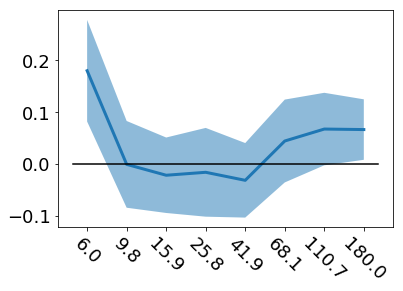

In [12]:
power_change_volt_local = np.stack(power_change_volt_local, 0)

x = np.logspace(np.log10(6), np.log10(180), 8)
y = np.nanmean(power_change_volt_local,axis=0)
e = np.nanstd(power_change_volt_local,axis=0)/np.sqrt(power_change_volt_local.shape[0]-1) * 1.96

fig, ax = plt.subplots()
ax.plot(np.log10(x), y, lw=3)
ax.fill_between(np.log10(x), y-e, y+e, alpha=.5)
ax.plot(ax.get_xlim(),[0,0],'-k')
_=ax.set_xticks(np.log10(x))
_=ax.set_xticklabels(['{0:.1f}'.format(f) for f in x], rotation=-45)



[ 0.20850324  0.07395717  0.01663374 -0.04001629 -0.02875146  0.02937283
  0.06698161  0.07164151]


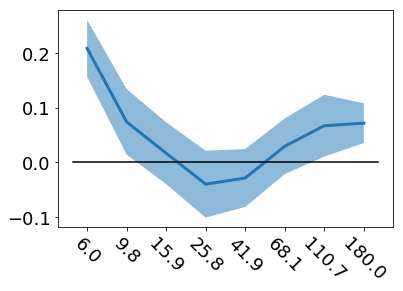

In [510]:
power_change_local = np.stack(power_change_local, 0)

x = np.logspace(np.log10(6), np.log10(180), 8)
y = np.nanmean(power_change_local,axis=0)
print(y)
e = np.nanstd(power_change_local,axis=0)/np.sqrt(power_change_local.shape[0]-1) * 1.96

fig, ax = plt.subplots()
ax.plot(np.log10(x), y, lw=3)
ax.fill_between(np.log10(x), y-e, y+e, alpha=.5)
ax.plot(ax.get_xlim(),[0,0],'-k')
_=ax.set_xticks(np.log10(x))
_=ax.set_xticklabels(['{0:.1f}'.format(f) for f in x], rotation=-45)




In [512]:
ttest_1samp(power_change_volt_local,0, nan_policy='omit')

Ttest_1sampResult(statistic=masked_array(data = [3.3149213440388867 -0.02194916033748256 -0.5473835776137029
 -0.34501570907643764 -0.8004059507224399 0.9962451946492135
 1.735136848166964 2.049970723324135],
             mask = [False False False False False False False False],
       fill_value = 1e+20)
, pvalue=masked_array(data = [ 0.00301972  0.98267782  0.58938797  0.73321779  0.43166605  0.32949746
  0.09609885  0.05193587],
             mask = False,
       fill_value = 1e+20)
)

In [37]:
np.mean(power_change, axis=0).mean(axis=1)

array([ 0.54381283,  0.20493186, -0.08575836, -0.1326223 , -0.15473672,
       -0.04042533,  0.03384831, -0.01251869])